In [1]:
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import os
import re
import copy
import subprocess
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline  
import matplotlib

In [2]:
(sr,y) = wav.read('test_wav/diarizationExample.wav')

In [3]:
#calculate duration of the audio
def audio_duration(y,sr):
    return len(y)/sr
#get the number of frames
def get_nFrames(y,sr,winStep=0.010 ):
    num_frames = int(len(y)/(winStep*sr)) - 1    
    return num_frames
def Sample2sec(sample, sr):
    return sample/sr
def Sec2sample(sec, sr):
    return int(sec*sr)
def Frame2sec(frame, nframes, duration):
    return (frame*duration)/nframes
def Sec2Frame(sec, nframes, duration):
    return int((sec*nframes)/duration)
def findClusterPosition(diarfile):
    cluster_idx = []
    for i in range(len(diarfile)):
        aux_line = diarfile[i]
        if len([m.start() for m in re.finditer(';;', diarfile[i])])>0:
            cluster_idx.append(i)
    nclusters = len(cluster_idx)
    return cluster_idx, nclusters
def FindSegments_Frame(diarfile, cluster_idx, nclusters):
    ClusterSegs = []
    for i in range(nclusters):
        if(i<(nclusters-1)):
            segsClus_i = diarfile[cluster_idx[i]+1:cluster_idx[i+1]]
        else:
            segsClus_i = diarfile[cluster_idx[i]+1:]
        SegsCluster_j = []
        for j in range(len(segsClus_i)):
            seg_j = segsClus_i[j]
            spaces = [m.start() for m in re.finditer(' ', seg_j)]
            fr_start = int(seg_j[(spaces[1]+1):spaces[2]])
            fr_end = int(seg_j[(spaces[2]+1):spaces[3]]) + fr_start
            SegsCluster_j.append([fr_start, fr_end])
        ClusterSegs.append(SegsCluster_j)
    return ClusterSegs
def FindSegments_Secs(Segments_Frame, nframes, duration):
    ClusterSegs = copy.deepcopy(Segments_Frame)
    for cluster_id,i in enumerate(Segments_Frame):
        for seg_id,j in enumerate(i):
            ClusterSegs[cluster_id][seg_id][0] = Frame2sec(j[0], nframes, duration)
            ClusterSegs[cluster_id][seg_id][1] = Frame2sec(j[1], nframes, duration)
    return ClusterSegs
def FindSegments_Samples(Segments_Sec, sr):
    ClusterSegs = copy.deepcopy(Segments_Sec)
    for cluster_id,i in enumerate(Segments_Sec):
        for seg_id,j in enumerate(i):
            ClusterSegs[cluster_id][seg_id][0] = Sec2sample(j[0], sr)
            ClusterSegs[cluster_id][seg_id][1] = Sec2sample(j[1], sr)
    return ClusterSegs
#function to plot 
def plot_clusteredSignal(y, Segments_Sample):
    #plt.plot(y)  
    plt.axis([0,len(y),-33000,33000])
    x = np.linspace(0,len(y), num= len(y), dtype=int)
    colors = plt.cm.tab10(np.linspace(start=0, stop=10, dtype=int, num=len(Segments_Sample)))
    for clus_idx,i in enumerate(Segments_Sample):
        for seg_idx,j in enumerate(i): 
            print(j[0], j[1])            
            plt.plot(x[j[0]:j[1]], y[j[0]:j[1]], color = colors[clus_idx])
    plt.show()
def plot_clusteredSignal_inSecs(y,sr, Segments_Sample):
    #plt.plot(y)  
    plt.axis([0,len(y)/sr,-33000,33000])
    x = np.linspace(0,len(y)/sr, num= len(y), dtype=int)
    colors = plt.cm.tab10(np.linspace(start=0, stop=10, dtype=int, num=len(Segments_Sample)))
    for clus_idx,i in enumerate(Segments_Sample):
        for seg_idx,j in enumerate(i): 
            print(j[0], j[1])            
            plt.plot(x[j[0]:j[1]], y[j[0]:j[1]], color = colors[clus_idx])
    plt.show()


In [75]:
filename = 'outFolderTeste/diarizationExample/diarizationExample.h.3.seg'
with open(filename) as f:
    diarfile = f.readlines()

In [76]:
diarfile

[';; cluster S0 \n',
 'diarizationExample 1 0 674 U U U S0\n',
 ';; cluster S12 \n',
 'diarizationExample 1 674 480 U U U S12\n',
 'diarizationExample 1 1587 293 U U U S12\n',
 'diarizationExample 1 2795 585 U U U S12\n',
 ';; cluster S14 \n',
 'diarizationExample 1 3380 817 U U U S14\n',
 ';; cluster S5 \n',
 'diarizationExample 1 1154 433 U U U S5\n',
 'diarizationExample 1 1880 915 U U U S5\n']

0 107875
107875 184701
254004 300900
447349 540980
540980 671744
184701 254004
300900 447349


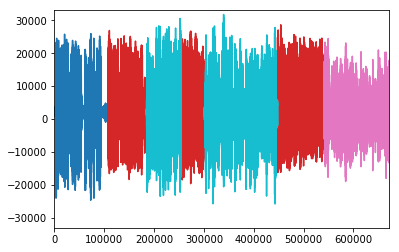

In [77]:
Segments_Frame = []
duration = audio_duration(y,sr)
nframes = get_nFrames(y,sr,winStep=0.010)
cluster_idx, nclusters = findClusterPosition(diarfile)
Segments_Frame = FindSegments_Frame(diarfile, cluster_idx, nclusters)
Segments_Sec = FindSegments_Secs(Segments_Frame, nframes, duration)
Segments_Sample = FindSegments_Samples(Segments_Sec, sr)
plot_clusteredSignal(y, Segments_Sample)

In [78]:
Segments_Frame

[[[0, 674]],
 [[674, 1154], [1587, 1880], [2795, 3380]],
 [[3380, 4197]],
 [[1154, 1587], [1880, 2795]]]

0 107875
107875 184701
254004 300900
447349 540980
540980 671744
184701 254004
300900 447349


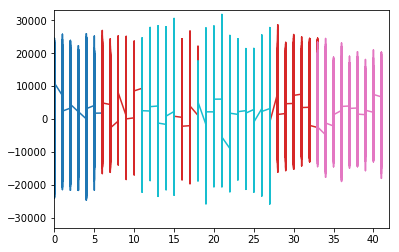

In [79]:
plot_clusteredSignal_inSecs(y,sr, Segments_Sample)

In [80]:
out_path = 'audios_segmentadosTestes/4694/'
for i in range(nclusters):
    curr_cluster = Segments_Sample[i]    
    for j in range(len(curr_cluster)):
        start = curr_cluster[j][0]
        end = curr_cluster[j][1]
        y_aux = y[start:end]
        filename = 'spk_'+str(i)+'Seg_'+str(j)+'.wav'
        wav.write(out_path+filename, sr, y_aux)
        
    

In [81]:
Segments_Frame

[[[0, 674]],
 [[674, 1154], [1587, 1880], [2795, 3380]],
 [[3380, 4197]],
 [[1154, 1587], [1880, 2795]]]

In [82]:
# cria os rótulos para cada frame
labels = np.zeros(nframes)
for lbl,spks in enumerate(Segments_Frame):
    for segs in spks:
        init = segs[0]
        end = segs[1]
        labels[init:end] = lbl        

In [83]:
#janelamento dos dados
from scipy.stats import mode
win_size = 50
win_step = 5
num_win = int(nframes/win_step)
new_lbl = np.zeros(num_win)
for i in range(num_win):
    init = i*win_step
    end = init+win_size
    print([init,end])
    new_lbl[i] = mode(labels[init:end])[0][0]


[0, 50]
[5, 55]
[10, 60]
[15, 65]
[20, 70]
[25, 75]
[30, 80]
[35, 85]
[40, 90]
[45, 95]
[50, 100]
[55, 105]
[60, 110]
[65, 115]
[70, 120]
[75, 125]
[80, 130]
[85, 135]
[90, 140]
[95, 145]
[100, 150]
[105, 155]
[110, 160]
[115, 165]
[120, 170]
[125, 175]
[130, 180]
[135, 185]
[140, 190]
[145, 195]
[150, 200]
[155, 205]
[160, 210]
[165, 215]
[170, 220]
[175, 225]
[180, 230]
[185, 235]
[190, 240]
[195, 245]
[200, 250]
[205, 255]
[210, 260]
[215, 265]
[220, 270]
[225, 275]
[230, 280]
[235, 285]
[240, 290]
[245, 295]
[250, 300]
[255, 305]
[260, 310]
[265, 315]
[270, 320]
[275, 325]
[280, 330]
[285, 335]
[290, 340]
[295, 345]
[300, 350]
[305, 355]
[310, 360]
[315, 365]
[320, 370]
[325, 375]
[330, 380]
[335, 385]
[340, 390]
[345, 395]
[350, 400]
[355, 405]
[360, 410]
[365, 415]
[370, 420]
[375, 425]
[380, 430]
[385, 435]
[390, 440]
[395, 445]
[400, 450]
[405, 455]
[410, 460]
[415, 465]
[420, 470]
[425, 475]
[430, 480]
[435, 485]
[440, 490]
[445, 495]
[450, 500]
[455, 505]
[460, 510]
[465, 515

In [84]:
new_lbl

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [88]:
#plot the signal according the label color
#passa por todos os conjuntos de 500 frames e armazena o frame de inicio, caso ocorra alguma mudança de rótulo 
#do anterior para o atual, então o segmento final é igual ao segmento inicial do frame atual + int(step/2)
aux_cont=0
label_final=[]
for i in range(len(new_lbl)):
    if (i==0):
        prev_lbl = new_lbl[i]
        curr_lbl = new_lbl[i]
        init_seg = 0
        end_seg = int(init_seg +  (win_step/2))
    else:
        curr_lbl = new_lbl[i]        
        if(curr_lbl == prev_lbl):            
            end_seg += win_step           
        else:
            print('Mudou!!!')
            label_final.append([init_seg,end_seg,prev_lbl])
            init_seg = end_seg
            end_seg = int(init_seg +  (win_step/2))
            prev_lbl = curr_lbl
    if(i == (len(new_lbl)-1)):
        label_final.append([init_seg,nframes,prev_lbl])
    print(curr_lbl)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Mudou!!!
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Mudou!!!
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.

In [89]:
label_final

[[0, 647, 0.0],
 [647, 1124, 1.0],
 [1124, 1556, 3.0],
 [1556, 1848, 1.0],
 [1848, 2755, 3.0],
 [2755, 3342, 1.0],
 [3342, 4197, 2.0]]

In [ ]:
#plot the signal
for i in label_final:
    

In [ ]:
#probabilidade de cada janela:
#Seja alpha a % de overlap (calculado como win_step/win_size): a probabilidade de uma classe dentro de cada 

In [ ]:
https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

In [ ]:
https://matplotlib.org/examples/pylab_examples/multicolored_line.html

## Visualize the feature Space

In [12]:
frame_size = 0.025
frame_stride = 0.01

In [13]:
frame_length, frame_step = frame_size * sr, frame_stride * sr
frame_length, frame_step

(400.0, 160.0)

In [14]:
signal_length = len(y)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

In [15]:
print(signal_length)
print(frame_length)
print(frame_step)
print(num_frames)

671744
400
160
4196


In [16]:
sr

16000

In [17]:
#extract mfccs
mfcc_feat = mfcc(y,sr,appendEnergy=True, numcep=13)
#

In [18]:
mfcc_feat.shape

(4197, 13)

In [19]:
delta_feat = delta(feat=mfcc_feat, N=1)

In [20]:
delta_feat.shape

(4197, 13)

In [21]:
sr

16000

In [22]:
X= pd.DataFrame(mfcc_feat)
X2 = pd.DataFrame(delta_feat)

In [23]:
labels = np.zeros(mfcc_feat.shape[0], dtype=int)
for idx,i in enumerate(Segments_Frame):
    for j in i:
        labels[j[0]:j[1]] = idx

In [24]:
#run pca
from sklearn.preprocessing import StandardScaler

In [25]:
X= StandardScaler().fit_transform(X)
X2= StandardScaler().fit_transform(X2)

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [28]:
finalDf = principalDf
finalDf['target'] = pd.Series(labels, index=finalDf.index)


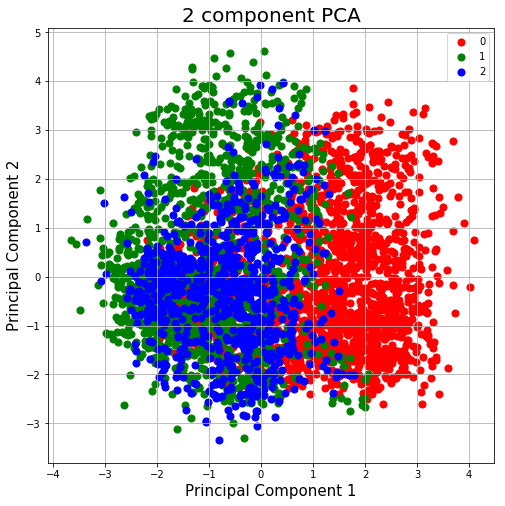

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [30]:
pca2 = PCA(n_components=2)

principalComponents2 = pca2.fit_transform(X2)

principalDf2 = pd.DataFrame(data = principalComponents2
             , columns = ['principal component 1', 'principal component 2'])

In [31]:
finalDf2 = principalDf2
finalDf2['target'] = pd.Series(labels, index=finalDf2.index)

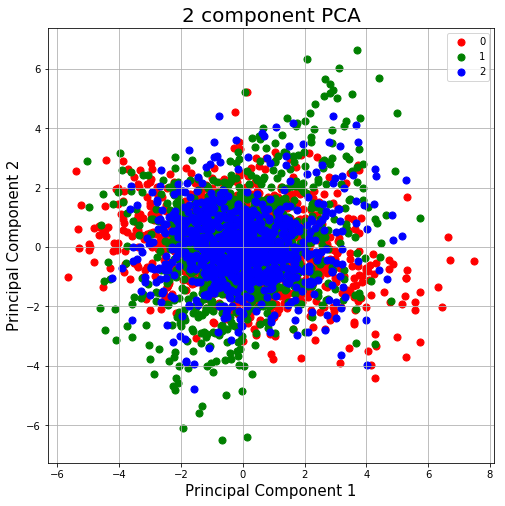

In [32]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf2['target'] == target
    ax.scatter(finalDf2.loc[indicesToKeep, 'principal component 1']
               , finalDf2.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [44]:
X2 = pd.DataFrame(X2)
y2 = finalDf2['target']

In [ ]:
grr2 = pd.plotting.scatter_matrix(X2, c=y2, figsize=(15, 15), marker='.',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

In [34]:
X = pd.DataFrame(X)
y = finalDf['target']

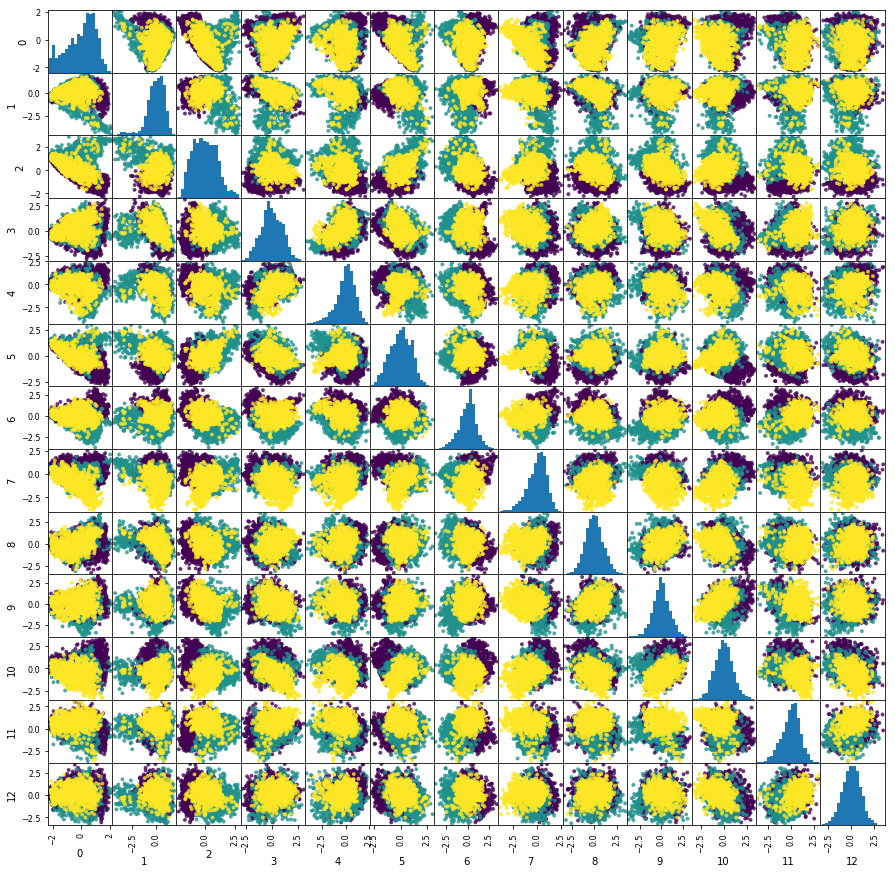

In [83]:
grr = pd.plotting.scatter_matrix(X, c=y, figsize=(15, 15), marker='.',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

In [ ]:
http://www-lium.univ-lemans.fr/diarization/doku.php/programmes

In [35]:
import seaborn as sns
X['target'] = y


In [ ]:
sns.pairplot(X, kind="scatter", hue="target", markers=["o", "s", "D"], palette="Set2")
plt.show()

4197

In [62]:
Segments_Frame

[[[0, 674], [1108, 1586], [1887, 2795]],
 [[674, 1108], [1586, 1887], [2795, 3444]],
 [[3444, 4197]]]

In [60]:
labels[1:10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
#teste, lendo e modificando os arquivos

input_files = 'inputfolder=./inputfolderTeste '
output_files = 'outputfolder=./outfolderTeste'




In [32]:
s = open("goTestes2.sh").read()

In [33]:
s

'inputfolder=./testaudios \noutputfolder=./out_testesaudios\n\nmkdir -p $outputfolder\n\nfor file in $inputfolder/*.wav\ndo\n echo "Processing $file"\n ./ilp_diarization2Testes.sh $file 120 $outputfolder\ndone\n\n\n\n#why 120?\n#http://www.mickael-rouvier.fr/files/cross-show_diarization.pdf\n\n\n\n\n'

In [35]:
start_in = 'inputfolder='
end_in = ' '

folder_wav = start_in + './inputfolderTeste'
folder_wav

'inputfolder=./inputfolderTeste'

In [38]:
pattern = re.search('%s(.*)%s' % (start_in, end_in), s).group(0)
pattern

'inputfolder=./testaudios '

In [40]:
s = s.replace(pattern, folder_wav)
s

'inputfolder=./inputfolderTeste\noutputfolder=./out_testesaudios\n\nmkdir -p $outputfolder\n\nfor file in $inputfolder/*.wav\ndo\n echo "Processing $file"\n ./ilp_diarization2Testes.sh $file 120 $outputfolder\ndone\n\n\n\n#why 120?\n#http://www.mickael-rouvier.fr/files/cross-show_diarization.pdf\n\n\n\n\n'

In [41]:
start_out = 'outputfolder='
end_out = '\n'

folder_out = start_out + './outFolderTeste'
folder_out

'outputfolder=./outFolderTeste'

In [42]:
pattern2 = re.search('%s(.*)%s' % (start_out, end_out), s).group(0)
pattern2

'outputfolder=./out_testesaudios\n'

In [43]:
s = s.replace(pattern2, folder_out)
s

'inputfolder=./inputfolderTeste\noutputfolder=./outFolderTeste\nmkdir -p $outputfolder\n\nfor file in $inputfolder/*.wav\ndo\n echo "Processing $file"\n ./ilp_diarization2Testes.sh $file 120 $outputfolder\ndone\n\n\n\n#why 120?\n#http://www.mickael-rouvier.fr/files/cross-show_diarization.pdf\n\n\n\n\n'

In [44]:
f = open("goTestes2.sh", 'w')
f.write(s)
f.close()

AttributeError: 'NoneType' object has no attribute 'group'

In [25]:
spaces = [m.start() for m in re.finditer(' ', s)]

In [26]:
equals = [m.start() for m in re.finditer('=', s)]

In [27]:
spaces

[24, 64, 67, 86, 91, 94, 117, 122, 134, 142, 170, 176, 180, 207]

In [28]:
equals

[11, 38]